In [1]:
import torch
from cfm.datasets import EpochShufflePairDataset, sample_toy
from cfm import SimpleFlowModel, Trainer, FlowModelPipeline, PathConfig
import matplotlib.pyplot as plt

## Datasets

Sampling moons with noise=0.05


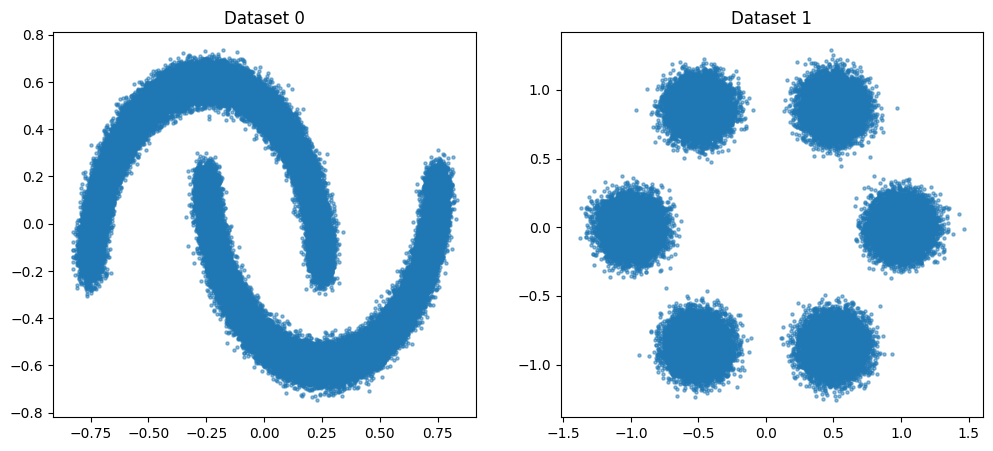

In [2]:
x_source = sample_toy('moons', n_samples=100000, noise=0.05)
x_target = sample_toy('6gaussians', n_samples=100000, noise=0.1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(x_source[:, 0], x_source[:, 1], s=5, alpha=0.5)
plt.title('Dataset 0')
plt.subplot(1, 2, 2)
plt.scatter(x_target[:, 0], x_target[:, 1], s=5, alpha=0.5)
plt.title('Dataset 1')
plt.show()

## Train the model

### I-CFM: moon->6gaussians

In [ ]:
# PathName = Literal[
#     "flow_matching",              # Lipman et al. 2023
#     "rectified_flow",             # Liu 2022
#     "vp_stochastic_interpolant",  # Albergo & Vanden-Eijnden 2023 (σ_t=0)
#     "independent_cfm",
#     "ot_cfm",                     # Tong et al.
#     "schrodinger_bridge_cfm",     # q(z)=π_{2σ^2}, σ_t=σ sqrt(t(1-t))
# ]

dataset = EpochShufflePairDataset(x_source, x_target)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)

method_cfg = PathConfig(name='independent_cfm', sigma=0.005)

flow_model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)

optimizer = torch.optim.Adam(flow_model.parameters(), lr=1e-3)

trainer = Trainer(flow_model, dataloader, optimizer=optimizer,
                  n_epochs=500, path_cfg=method_cfg)

trainer.train()

torch.save(flow_model.state_dict(), 'checkpoints/icfm_moon_6gaussians.pth')

Epoch [500/500] Path=independent_cfm Loss=0.262616: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


In [4]:
flow_model = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)
flow_model.load_state_dict(torch.load('checkpoints/icfm_moon_6gaussians.pth'))

pipeline_ot = FlowModelPipeline(flow_model, device='cpu')

# source dataset
seeds = sample_toy('moons', n_samples=10000, noise=0.05)
# targets = sample_toy('circles', n_samples=1000, noise=0.1)

pipeline_ot.generate_animation(
    seeds, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), n_steps=100,
    title = 'I-CFM: moon->6gaussians',
    save_path='assets/icfm_moon_6gaussians.mp4'
)

Sampling moons with noise=0.05


### Minibatch OT-CFM: moon->6gaussians

In [6]:
dataset = EpochShufflePairDataset(x_source, x_target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

flow_model_ot = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)

method_cfg = PathConfig(name='ot_cfm', sigma=0.005)
optimizer = torch.optim.Adam(flow_model_ot.parameters(), lr=1e-3)

trainer = Trainer(flow_model_ot, dataloader, optimizer=optimizer, n_epochs=500, path_cfg=method_cfg)
trainer.train()

torch.save(flow_model_ot.state_dict(), 'checkpoints/otcfm_moon_6gaussians.pth')

Epoch [500/500] Path=ot_cfm Loss=0.014069: 100%|██████████| 500/500 [34:35<00:00,  4.15s/it]


In [8]:
flow_model_ot = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)
flow_model_ot.load_state_dict(torch.load('checkpoints/otcfm_moon_6gaussians.pth'))

pipeline_ot = FlowModelPipeline(flow_model_ot, device='cpu')

# source dataset
seeds = sample_toy('moons', n_samples=10000, noise=0.05)
# targets = sample_toy('circles', n_samples=1000, noise=0.1)

pipeline_ot.generate_animation(
    seeds, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), n_steps=100,
    title = 'OT-CFM: moon->6gaussians',
    save_path='assets/otcfm_moon_6gaussians.mp4',
    color='red'
)

Sampling moons with noise=0.05


### SB-CFM: moon->6gaussians

In [13]:
dataset = EpochShufflePairDataset(x_source, x_target)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

flow_model_sb = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)

method_cfg = PathConfig(name='schrodinger_bridge_cfm', sigma=0.5) # unbalanced sinkhorn
optimizer = torch.optim.Adam(flow_model_sb.parameters(), lr=1e-3)

save_path = 'checkpoints/sb_cfm_moon_6gaussians.pth'
trainer = Trainer(flow_model_sb, dataloader, optimizer=optimizer, n_epochs=500, path_cfg=method_cfg, save_path=save_path)
trainer.train()

torch.save(flow_model_sb.state_dict(), save_path)

Epoch [500/500] Path=schrodinger_bridge_cfm Loss=1.152611: 100%|██████████| 500/500 [1:31:04<00:00, 10.93s/it]      


In [16]:
flow_model_sb = SimpleFlowModel(input_dim=2, time_dim=8, hidden_dim=128)
flow_model_sb.load_state_dict(torch.load(save_path))

pipeline_sb = FlowModelPipeline(flow_model_sb, device='cpu')

# source dataset
seeds = sample_toy('moons', n_samples=10000, noise=0.05)
# targets = sample_toy('circles', n_samples=1000, noise=0.1)

pipeline_sb.generate_animation(
    seeds, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5), n_steps=100,
    title = 'SB-CFM: moon->6gaussians',
    save_path='assets/sb_cfm_moon_6gaussians.mp4',
    color='blue'
)

Sampling moons with noise=0.05


In [17]:
from moviepy import VideoFileClip, clips_array

clip1 = VideoFileClip("assets/icfm_moon_6gaussians.mp4")
clip2 = VideoFileClip("assets/otcfm_moon_6gaussians.mp4")
clip3 = VideoFileClip("assets/sb_cfm_moon_6gaussians.mp4")

h = min(clip1.h, clip2.h, clip3.h)

clip1 = clip1.resized(height=h)
clip2 = clip2.resized(height=h)
clip3 = clip3.resized(height=h)

final = clips_array([[clip1, clip2, clip3]])
final.write_videofile("assets/comparison.mp4")

MoviePy - Building video assets/comparison.mp4.
MoviePy - Writing video assets/comparison.mp4



MoviePy - Done !
MoviePy - video ready assets/comparison.mp4
